# Semivariogram Regularization

In this tutorial we will learn how to regularize semivariogram of dataset consisting irregularly shaped polygons. The procedure of the semivariogram regularization is described in the study: `(1) Goovaerts P., Kriging and Semivariogram Deconvolution in the Presence of Irregular Geographical Units, Mathematical Geology 40(1), 101-128, 2008`.

The main idea is to retrieve the point support semivariogram from the semivariogram of irregular polygons. This is the case in the mining industry, where aggregated blocks are deconvoluted into smaller units, and in epidemiology, where data is aggregated over big administrative units. Or in ecology, where species observations are aggregated over areas or time windows.

In this tutorial, we use block data of Breast Cancer incidence rates in Northeastern counties of the U.S. and U.S. Census 2010 data for population blocks.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
  - kriging

- **Package**:
  - `TheoreticalVariogram()`
  - `Blocks()` - described in this tutorial, but this class has been used in **3-5-**
  - `PointSupport()` - described in this tutorial

- **Programming**:
  - Python basics
  - `pandas` basics

## Table of contents

1. Prepare data
2. Set semivariogram parameters
3. Regularize semivariogram
4. Visualize process
5. Export semivariogram

## 1. Prepare data

Data structures for semivariogram regularization are rather complex, and that's why Pyinterpolate has classes merging blocks and point support data. There are two structures:

- `Blocks()`: stores polygon and block data, transforms it, and retrieves centroids,
- `PointSupport()`: performs spatial joins between polygons and points support data and manages internal indexing of those datasets.

In [1]:
import geopandas as gpd

from pyinterpolate import build_experimental_variogram
from pyinterpolate import Blocks
from pyinterpolate import Deconvolution
from pyinterpolate import PointSupport

In [2]:
DATASET = '../data/blocks/cancer_data.gpkg'
OUTPUT = '../data/regularized_variogram.json'
POLYGON_LAYER = 'areas'
POPULATION_LAYER = 'points'
POP10 = 'POP10'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'

In [3]:
blocks = Blocks(
    ds=gpd.read_file(DATASET, layer=POLYGON_LAYER),
    value_column_name=POLYGON_VALUE,
    geometry_column_name=GEOMETRY_COL,
    index_column_name=POLYGON_ID
)

In [4]:
blocks.ds.head()

,FIPS,rate,geometry,representative_points,lon,lat
0,25019,192.2,"MULTIPOLYGON (((2115688.816 556471.24, 2115699...",POINT (2132629.599 557971.156),2.132630e+06,557971.155949
1,36121,166.8,"POLYGON ((1419423.43 564830.379, 1419729.721 5...",POINT (1442153.243 550673.936),1.442153e+06,550673.935704
2,33001,157.4,"MULTIPOLYGON (((1937530.728 779787.978, 193751...",POINT (1958207.02 766008.383),1.958207e+06,766008.383446
3,25007,156.7,"MULTIPOLYGON (((2074073.532 539159.504, 207411...",POINT (2082188.457 556830.822),2.082188e+06,556830.822367
4,25001,155.3,"MULTIPOLYGON (((2095343.207 637424.961, 209528...",POINT (2100746.85 600235.846),2.100747e+06,600235.845891


In [5]:
point_support = PointSupport(
    points=gpd.read_file(DATASET, layer=POPULATION_LAYER),
    blocks=blocks,
    points_value_column=POP10,
    points_geometry_column=GEOMETRY_COL,
    verbose=True
)

In [6]:
point_support.point_support.head()

,geometry,POP10,FIPS,lon,lat,total_POP10
0,POINT (1277277.671 441124.507),1866.0,42049.0,1.277278e+06,441124.5068,262794.0
1,POINT (1277277.671 431124.507),2093.0,42049.0,1.277278e+06,431124.5068,262794.0
2,POINT (1277277.671 421124.507),590.0,42039.0,1.277278e+06,421124.5068,89534.0
3,POINT (1277277.671 411124.507),636.0,42039.0,1.277278e+06,411124.5068,89534.0
4,POINT (1285937.925 446124.507),10191.0,42049.0,1.285938e+06,446124.5068,262794.0


## 2. Set semivariogram parameters

Now, we must set parameters for the areal semivariogram AND point support semivariogram. It is essential to understand data, especially experimental semivariances.

The *step size* and the *maximum search radius* parameters depend on the block data. But we should check the point's semivariogram too, just in case. We won't create meaningful results if point support data is spatially independent.

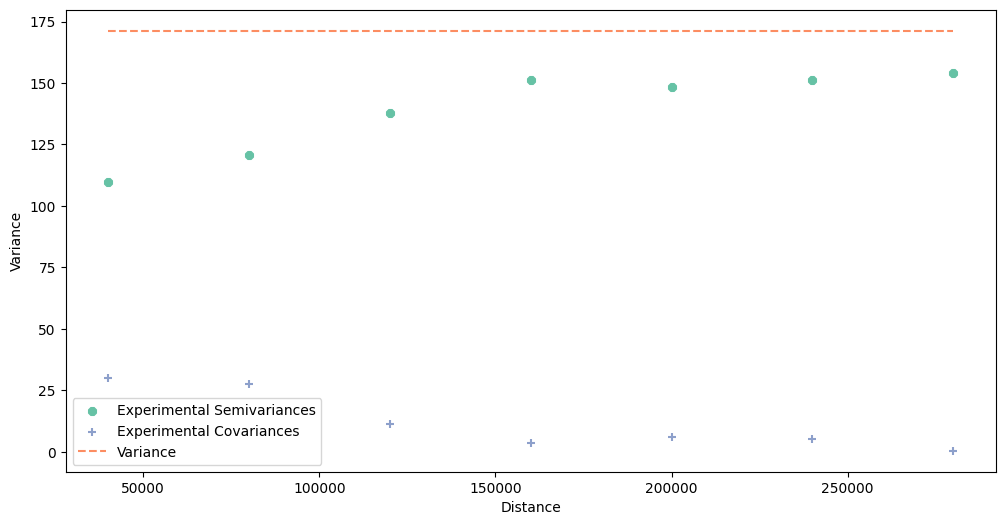

In [7]:
# Check experimental semivariogram of areal data - this cell may be run multiple times
# before you find optimal parameters

maximum_range = 300000
step_size = 40000

dt = blocks.block_data  # x, y, val
exp_semivar = build_experimental_variogram(ds=dt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

exp_semivar.plot()

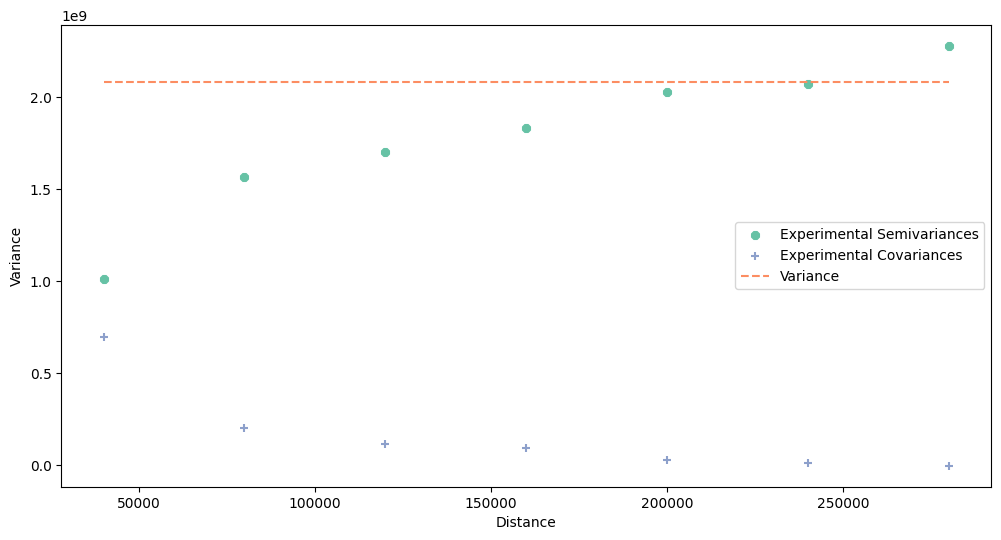

In [8]:
# Check experimental semivariogram of point data - this cell may be run multiple times
# before you find optimal parameters

maximum_point_range = 300000
step_size_points = 20000


pt = point_support.get_points_array()
exp_semivar = build_experimental_variogram(ds=pt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

exp_semivar.plot()

We see that the point support variogram follow a spatial-dependency pattern, but changes in semivariance within blocks is not pronounced ................. In this case, we can move to the next step - deconvolution. The next step is to create the Deconvolution object. We have multiple parameters to choose from, and it is hard to find the best fit initially, so try to avoid multiple loops because it is time-consuming.